##### Initializing the necessary libraries for building our ML Pipeline

In [8]:
# Import general purpose modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.inputs import TrainingInput
import boto3
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

### Loading the Training data
#### Since the training dataset is ~6GB in volume, we have implemented batching while loading the data into memory. More specifically, we have imported the data chunk by chunk and later concatenated all the chunks into a single consolidated dataframe.

In [2]:
data_location = 's3://msba6330-group1/result_files/train.csv'
chunksize = 10 ** 6
num_of_chunk = 0
train = pd.DataFrame()

for chunk in pd.read_csv(data_location, chunksize = chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=1, replace=False, random_state=123)], axis=0)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

train_len = len(train)
train_len


Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


8085793

##### Dropping Irrelevant columns from training as well as testing sets, for example:
##### 1 - index: This is an irrelevant column that is just an identifier
##### 2 - id: This is an irrelevant column that is just an identifier for Advertisements

In [3]:
train.drop(['index', 'id'], axis=1, inplace = True)

##### Let us look at the various columns present in our training and testing data

In [5]:
print('Columns present in Training Dataset are:\n',train.columns.to_list())

Columns present in Training Dataset are:
 ['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


### Now that we have our training and testing data, let us initialize our ML pipeline

##### We will be training a tree-based XGBoost model on our training set and making predictions on the test data post training. First, let's start with creating our training and testing sets to quantify the model performance

##### Since XGBoost does not organically support categorical columns such as the device_type and app_type present in our data, we will process those columns so that the model can be trained 

In [6]:
lbl = LabelEncoder()

train['site_id'] = lbl.fit_transform(train['site_id'].astype(str))
train['site_domain'] = lbl.fit_transform(train['site_domain'].astype(str))
train['site_category'] = lbl.fit_transform(train['site_category'].astype(str))
train['app_id'] = lbl.fit_transform(train['app_id'].astype(str))
train['app_domain'] = lbl.fit_transform(train['app_domain'].astype(str))
train['app_category'] = lbl.fit_transform(train['app_category'].astype(str))
train['device_id'] = lbl.fit_transform(train['device_id'].astype(str))
train['device_ip'] = lbl.fit_transform(train['device_ip'].astype(str))
train['device_model'] = lbl.fit_transform(train['device_model'].astype(str))

In [7]:
# All predictor variables
x = train.loc[:, ~train.columns.isin(['click'])]
y = train.loc[:, train.columns.isin(['click'])]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=93)

##### Initializing the XGBoost classifier and defining the hyperparameter search space

In [12]:
containers = {
                'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
}
role = get_execution_role()
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://msba6330-group1/result_files',
                                    sagemaker_session=sess)
xgb.set_hyperparameters(eta=0.1, objective='binary:logistic', num_round=25,class_weight = 'balanced', n_jobs=-1, n_estimators=500, max_depth=11, verbose = True) 
s3_input_train = TrainingInput(s3_data='s3://msba6330-group1/result_files/train.csv', content_type='csv')
xgb.fit({'train': s3_input_train})

[23:35:31] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




##### Making predictions on the test data

In [14]:
xgb_predictor = xgb.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    serializer = CSVSerializer())

y_pred = xgb.predict(x_test)
y_pred_probs = xgb.predict_proba(x_test)[:,1]


### Now that we have made the predictions, let us discuss the model performance in detail

##### Performance Measure 1 - Classification Report

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91   1342387
           1       0.56      0.11      0.18    274772

    accuracy                           0.83   1617159
   macro avg       0.70      0.55      0.55   1617159
weighted avg       0.79      0.83      0.78   1617159



##### Performance Measure 2 - ROC Curve (with AUC Score)

Area under the ROC curve (AUC) :  0.7529740397900867
ROC Curve


<Figure size 432x288 with 0 Axes>

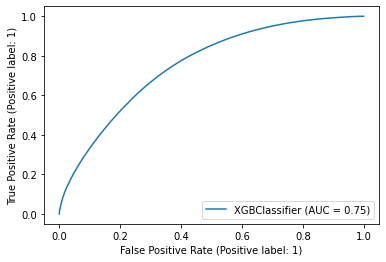

In [17]:
np.set_printoptions(precision=2)
print('Area under the ROC curve (AUC) : ',roc_auc_score(y_test, y_pred_probs))
print('ROC Curve')
plt.figure()
plot_roc_curve(xgb_clf, x_test, y_test)